## DSC 180A Quarter 1 Project

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np


In [3]:
from torchvision import datasets, transforms

# Define transform: converts images to tensors (0–1)
transform = transforms.Compose([
    transforms.ToTensor()
])

# Load CIFAR-10 (train split)
dataset = datasets.CIFAR10(
    root="./data",        # creates ./data automatically
    train=True,
    download=True,        # downloads if not found
    transform=transform
)

# Pick a few sample images
images, labels = zip(*[dataset[i] for i in range(5)])
images = torch.stack(images).numpy()  # shape: (5, 3, 32, 32)


100%|██████████| 170M/170M [01:42<00:00, 1.66MB/s] 


In [4]:
def add_laplace_noise(x, epsilon=1.0, sensitivity=1.0):
    scale = sensitivity / epsilon
    noise = np.random.laplace(0, scale, x.shape)
    return np.clip(x + noise, 0, 1)

def add_gaussian_noise(x, sigma=0.1):
    noise = np.random.normal(0, sigma, x.shape)
    return np.clip(x + noise, 0, 1)


In [5]:
laplace_images = add_laplace_noise(images, epsilon=2.0)
gaussian_images = add_gaussian_noise(images, sigma=0.1)


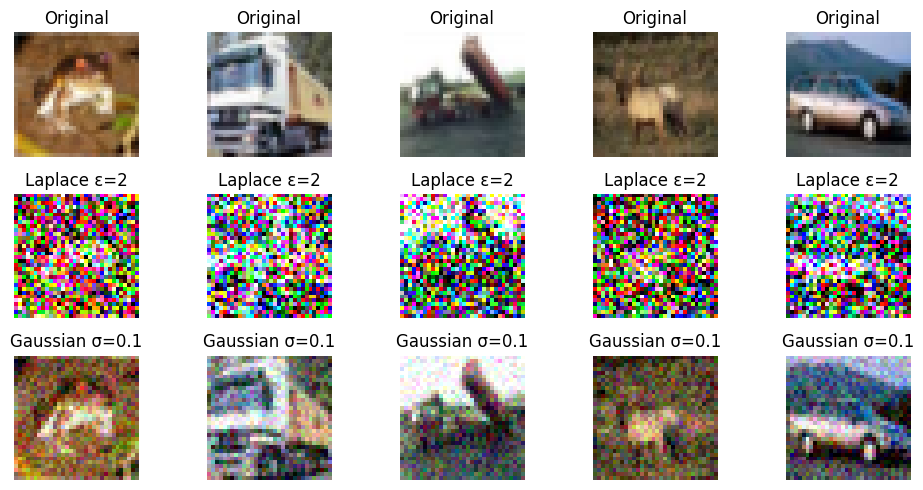

In [6]:
def show_images(orig, lap, gau):
    fig, axes = plt.subplots(3, len(orig), figsize=(10, 5))
    for i in range(len(orig)):
        axes[0, i].imshow(np.transpose(orig[i], (1, 2, 0)))
        axes[0, i].set_title("Original")
        axes[1, i].imshow(np.transpose(lap[i], (1, 2, 0)))
        axes[1, i].set_title("Laplace ε=2")
        axes[2, i].imshow(np.transpose(gau[i], (1, 2, 0)))
        axes[2, i].set_title("Gaussian σ=0.1")
        for ax in axes[:, i]:
            ax.axis("off")
    plt.tight_layout()
    plt.show()

show_images(images, laplace_images, gaussian_images)
